# Distillation de Connaissances pour la Génération d'Images avec Keras 3
## Génération de Chiffres Manuscrits : Transfert de Connaissances d'un VAE Teacher vers un VAE Student

## Objectifs de ce notebook

Dans ce notebook, nous allons explorer la **distillation de connaissances (Knowledge Distillation)** pour la **génération d'images** avec **Keras 3** :

1. **Comprendre la Distillation** - Transférer les connaissances d'un modèle complexe vers un modèle compact
2. **VAE (Variational Autoencoder)** - Architecture générative pour créer de nouvelles images
3. **Modèle Teacher** - VAE profond et performant mais lourd
4. **Modèle Student** - VAE léger qui apprend du Teacher
5. **Comparaison des approches** - Student seul vs Student avec distillation
6. **Génération d'images** - Créer de nouveaux chiffres authentiques

Nous utiliserons le célèbre dataset **MNIST** (60,000 images de chiffres manuscrits) pour entraîner nos modèles génératifs.

## Pourquoi la Distillation de Connaissances ?

**La distillation de connaissances** permet de :
- **Compresser un modèle** : Transférer les performances d'un modèle lourd vers un modèle léger
- **Améliorer l'apprentissage** : Le Student apprend mieux grâce aux connaissances du Teacher
- **Déploiement efficace** : Modèle final plus rapide et moins gourmand en ressources
- **Préserver la qualité** : Performances proches du Teacher avec une fraction des paramètres

**Keras 3** offre :
- **API moderne** : Code simple et élégant
- **Flexibilité** : Personnalisation facile des architectures
- **Performance** : Backend TensorFlow optimisé
- **Multi-backend** : Compatible TensorFlow, JAX, PyTorch

## 📚 Concepts clés que nous allons explorer

- **VAE (Variational Autoencoder)** : Modèle génératif probabiliste
- **Espace latent** : Représentation compressée et continue des images
- **Knowledge Distillation** : Transfert de connaissances Teacher → Student
- **Soft Targets** : Utiliser les sorties du Teacher comme labels enrichis
- **Loss combinée** : Reconstruction + KL divergence + Distillation
- **Comparaison** : Student seul vs Student avec distillation

## 🎯 Architecture du notebook

```
Installation → Théorie Distillation → VAE Teacher (profond) → VAE Student (léger) → 
Student seul → Student avec Distillation → Comparaison → Génération d'images
```

## 1. Installation et Configuration

In [117]:
# Installation des dépendances (décommentez si nécessaire)
# !pip install -q tensorflow>=2.16.0
# !pip install -q keras>=3.0.0

print("✅ Installation terminée !")

✅ Installation terminée !


In [118]:
# Bibliothèques principales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import warnings
import os
warnings.filterwarnings('ignore')

# Configurer Keras pour utiliser TensorFlow backend
os.environ['KERAS_BACKEND'] = 'tensorflow'

# TensorFlow et Keras 3
import tensorflow as tf
import keras
from keras import layers, models, ops, callbacks

# Configuration GPU
try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU(s) détecté(s): {len(gpus)} - Croissance mémoire activée")
    else:
        print("⚠️  Aucun GPU détecté - Utilisation du CPU")
except Exception as e:
    print(f"Configuration GPU: {e}")

# Configuration graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Reproductibilité
keras.utils.set_random_seed(42)
np.random.seed(42)
tf.random.set_seed(42)

print(f"\n📦 Versions des bibliothèques :")
print(f"  - TensorFlow : {tf.__version__}")
print(f"  - Keras      : {keras.__version__}")
print(f"  - Backend    : {keras.backend.backend()}")

print(f"\n🚀 Prêt pour la distillation de connaissances avec Keras 3 !")

✅ GPU(s) détecté(s): 1 - Croissance mémoire activée

📦 Versions des bibliothèques :
  - TensorFlow : 2.19.1
  - Keras      : 3.12.0
  - Backend    : tensorflow

🚀 Prêt pour la distillation de connaissances avec Keras 3 !


## 2. Comprendre la Distillation de Connaissances

### 2.1 Qu'est-ce que la Distillation de Connaissances ?

La **distillation de connaissances** (Knowledge Distillation) est une technique qui permet de **transférer les connaissances** d'un modèle complexe (Teacher) vers un modèle plus simple (Student).

#### Analogie : Le Professeur et l'Élève

Imaginez un professeur expérimenté qui enseigne à un élève :
- **Teacher (Professeur)** : Modèle profond, lourd, très performant mais lent
- **Student (Élève)** : Modèle léger, rapide mais moins performant... au départ !
- **Distillation** : L'élève apprend non seulement les réponses correctes, mais aussi le *raisonnement* du professeur
- **Résultat** : Un élève compact qui performe presque aussi bien que le professeur

### 2.2 Pourquoi la Distillation ?

#### Problème : Modèles lourds en production
- **Teacher** : 10M paramètres, 100ms d'inférence, 40MB de mémoire
- **Production** : Besoin de rapidité, faible latence, déploiement mobile

#### Solution : Distillation
- **Student distillé** : 1M paramètres, 10ms d'inférence, 4MB de mémoire
- **Performance** : 95% de la qualité du Teacher avec 10% des paramètres !

### 2.3 Comment ça marche ?

#### 🎓 Entraînement classique (Student seul)
```
Images → Student → Prédictions → Comparaison avec labels réels → Loss
```
- Le Student apprend uniquement des labels "durs" (0 ou 1)
- Perd beaucoup d'informations

#### 🔬 Entraînement avec Distillation
```
Images → Teacher → Soft Predictions (riches en info) ↓
Images → Student → Prédictions → Comparaison avec Teacher → Loss combinée
```
- Le Student apprend des "soft targets" du Teacher
- Capture les nuances et les incertitudes
- Meilleure généralisation !

### 2.4 La Loss de Distillation

Pour la génération d'images avec VAE, on combine plusieurs losses :

**Loss totale = α × Loss_reconstruction + β × Loss_KL + γ × Loss_distillation**

Où :
- **Loss_reconstruction** : Qualité de la reconstruction de l'image
- **Loss_KL** : Régularisation de l'espace latent (divergence KL)
- **Loss_distillation** : Similarité entre les représentations Teacher et Student

### 2.5 Visualisation de la Distillation

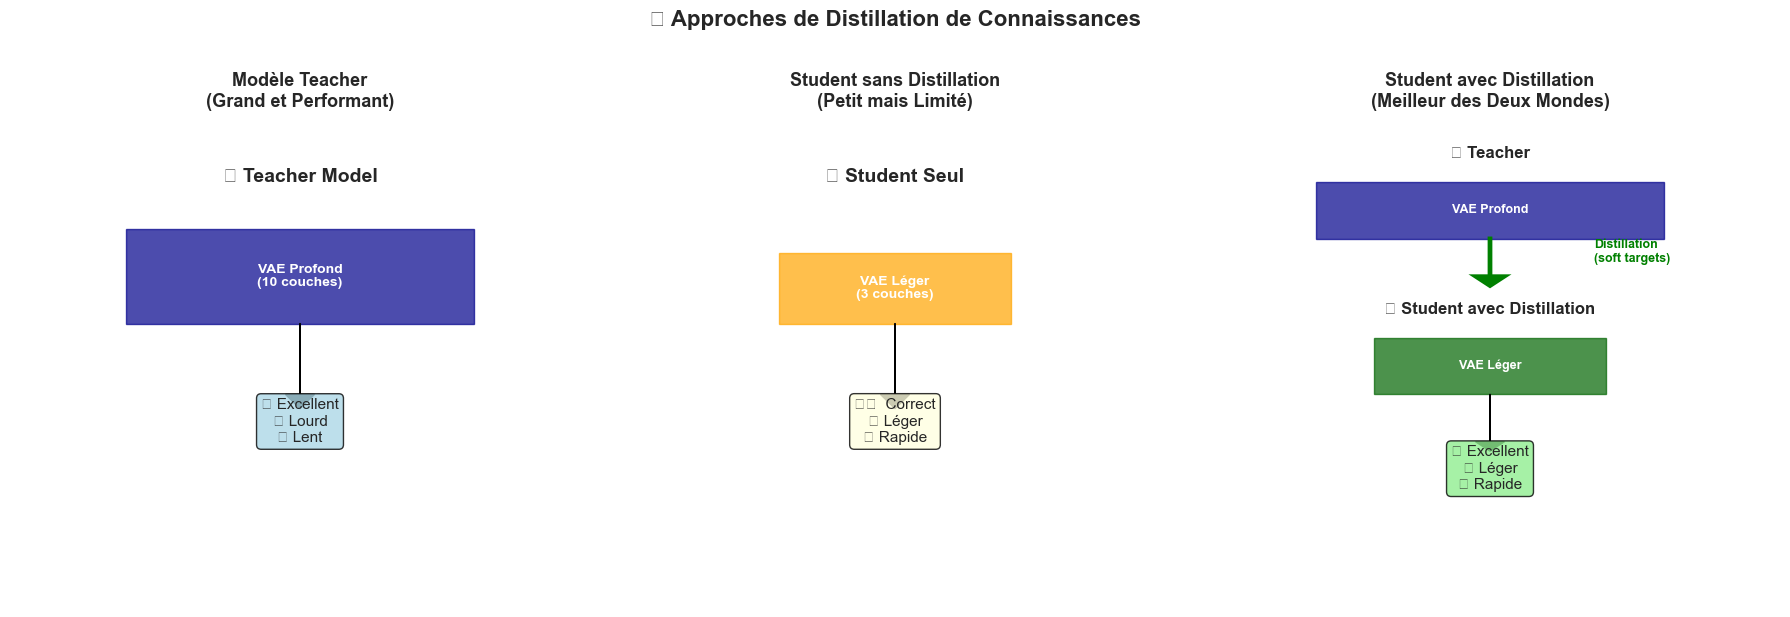


💡 Dans ce notebook, nous allons comparer Student seul vs Student avec Distillation !


In [119]:
# Visualisation des approches d'entraînement
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Approche 1: Teacher seul
ax = axes[0]
ax.text(0.5, 0.9, '🎓 Teacher Model', ha='center', fontsize=14, fontweight='bold')
ax.add_patch(plt.Rectangle((0.2, 0.6), 0.6, 0.2, color='darkblue', alpha=0.7))
ax.text(0.5, 0.7, 'VAE Profond\n(10 couches)', ha='center', va='center', color='white', fontweight='bold')
ax.arrow(0.5, 0.6, 0, -0.15, head_width=0.05, head_length=0.03, fc='black', ec='black')
ax.text(0.5, 0.35, '✅ Excellent\n❌ Lourd\n❌ Lent', ha='center', fontsize=11, 
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')
ax.set_title('Modèle Teacher\n(Grand et Performant)', fontsize=13, fontweight='bold', pad=20)

# Approche 2: Student seul
ax = axes[1]
ax.text(0.5, 0.9, '🎒 Student Seul', ha='center', fontsize=14, fontweight='bold')
ax.add_patch(plt.Rectangle((0.3, 0.6), 0.4, 0.15, color='orange', alpha=0.7))
ax.text(0.5, 0.675, 'VAE Léger\n(3 couches)', ha='center', va='center', color='white', fontweight='bold', fontsize=10)
ax.arrow(0.5, 0.6, 0, -0.15, head_width=0.05, head_length=0.03, fc='black', ec='black')
ax.text(0.5, 0.35, '⚠️  Correct\n✅ Léger\n✅ Rapide', ha='center', fontsize=11,
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')
ax.set_title('Student sans Distillation\n(Petit mais Limité)', fontsize=13, fontweight='bold', pad=20)

# Approche 3: Distillation
ax = axes[2]
ax.text(0.5, 0.95, '🎓 Teacher', ha='center', fontsize=12, fontweight='bold')
ax.add_patch(plt.Rectangle((0.2, 0.78), 0.6, 0.12, color='darkblue', alpha=0.7))
ax.text(0.5, 0.84, 'VAE Profond', ha='center', va='center', color='white', fontweight='bold', fontsize=9)
ax.arrow(0.5, 0.78, 0, -0.08, head_width=0.05, head_length=0.02, fc='green', ec='green', linewidth=3)
ax.text(0.68, 0.73, 'Distillation\n(soft targets)', fontsize=9, color='green', fontweight='bold')
ax.text(0.5, 0.62, '🎒 Student avec Distillation', ha='center', fontsize=12, fontweight='bold')
ax.add_patch(plt.Rectangle((0.3, 0.45), 0.4, 0.12, color='darkgreen', alpha=0.7))
ax.text(0.5, 0.51, 'VAE Léger', ha='center', va='center', color='white', fontweight='bold', fontsize=9)
ax.arrow(0.5, 0.45, 0, -0.1, head_width=0.05, head_length=0.02, fc='black', ec='black')
ax.text(0.5, 0.25, '✅ Excellent\n✅ Léger\n✅ Rapide', ha='center', fontsize=11,
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')
ax.set_title('Student avec Distillation\n(Meilleur des Deux Mondes)', fontsize=13, fontweight='bold', pad=20)

plt.suptitle('🔬 Approches de Distillation de Connaissances', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n💡 Dans ce notebook, nous allons comparer Student seul vs Student avec Distillation !")

## 3. Chargement et Exploration du Dataset MNIST

### 3.1 Présentation du dataset

**MNIST** (Modified National Institute of Standards and Technology) est un dataset classique en computer vision :
- **60,000 images** d'entraînement
- **10,000 images** de test
- **Résolution** : 28x28 pixels en niveaux de gris
- **10 classes** : Chiffres de 0 à 9
- **Objectif** : Générer de nouveaux chiffres réalistes avec un VAE

In [120]:
# Charger le dataset MNIST
print("📥 Chargement du dataset MNIST...")
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalisation et reshape
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Ajouter la dimension channel
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print(f"\n✅ Dataset chargé avec succès !")
print(f"\n📊 Statistiques du dataset :")
print(f"  - Images d'entraînement : {x_train.shape[0]:,}")
print(f"  - Images de test        : {x_test.shape[0]:,}")
print(f"  - Shape des images      : {x_train.shape[1:]}")
print(f"  - Plage de valeurs      : [{x_train.min():.2f}, {x_train.max():.2f}]")
print(f"  - Labels uniques        : {np.unique(y_train)}")

📥 Chargement du dataset MNIST...

✅ Dataset chargé avec succès !

📊 Statistiques du dataset :
  - Images d'entraînement : 60,000
  - Images de test        : 10,000
  - Shape des images      : (28, 28, 1)
  - Plage de valeurs      : [0.00, 1.00]
  - Labels uniques        : [0 1 2 3 4 5 6 7 8 9]


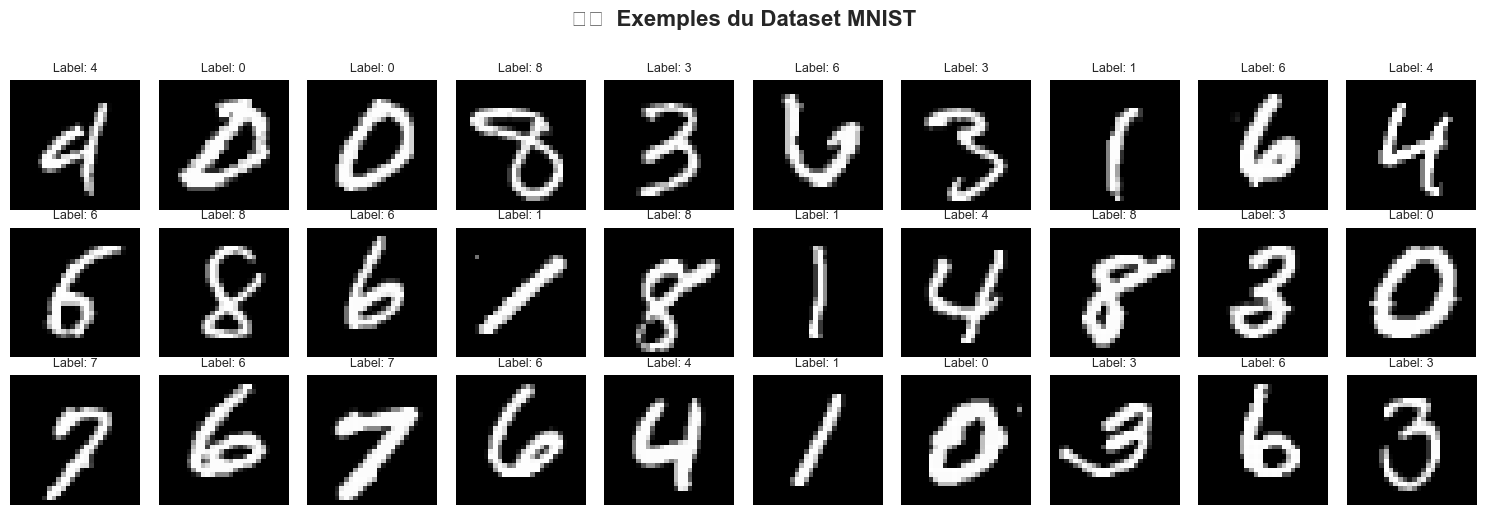


💡 Ces images serviront à entraîner nos VAE pour la génération !


In [121]:
# Visualisation d'exemples du dataset
fig, axes = plt.subplots(3, 10, figsize=(15, 5))
fig.suptitle('🖼️  Exemples du Dataset MNIST', fontsize=16, fontweight='bold', y=1.02)

for i in range(3):
    for j in range(10):
        idx = np.random.randint(0, len(x_train))
        axes[i, j].imshow(x_train[idx].squeeze(), cmap='gray')
        axes[i, j].set_title(f'Label: {y_train[idx]}', fontsize=9)
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

print("\n💡 Ces images serviront à entraîner nos VAE pour la génération !")

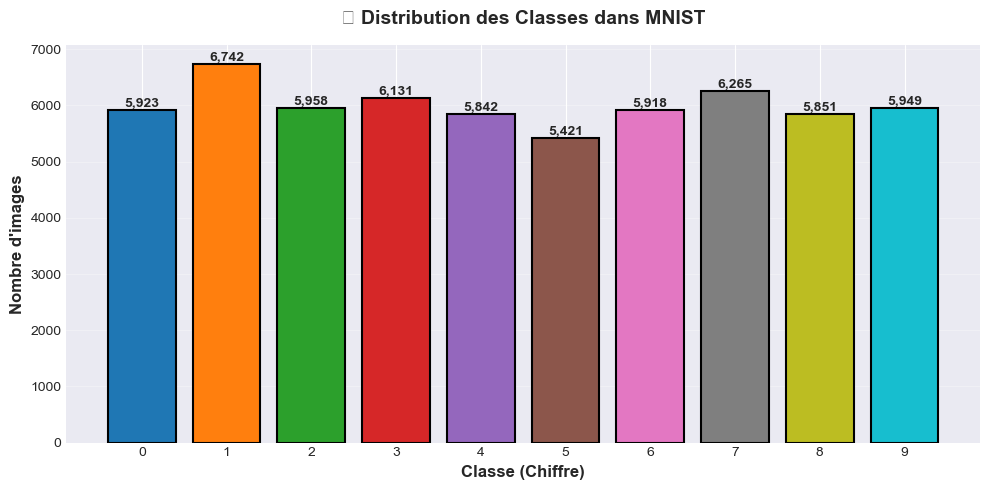


✅ Dataset bien équilibré : ~6,000 images par classe


In [122]:
# Distribution des classes
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

unique, counts = np.unique(y_train, return_counts=True)
colors = plt.cm.tab10(np.linspace(0, 1, 10))
bars = ax.bar(unique, counts, color=colors, edgecolor='black', linewidth=1.5)

ax.set_xlabel('Classe (Chiffre)', fontsize=12, fontweight='bold')
ax.set_ylabel('Nombre d\'images', fontsize=12, fontweight='bold')
ax.set_title('📊 Distribution des Classes dans MNIST', fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(unique)
ax.grid(axis='y', alpha=0.3)

# Ajouter les valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✅ Dataset bien équilibré : ~{int(np.mean(counts)):,} images par classe")

## 4. Architecture VAE (Variational Autoencoder)

### 4.1 Qu'est-ce qu'un VAE ?

Le **VAE (Variational Autoencoder)** est un modèle génératif qui apprend à :
1. **Encoder** : Compresser une image dans un espace latent (représentation compacte)
2. **Décoder** : Reconstruire l'image depuis l'espace latent
3. **Générer** : Créer de nouvelles images en échantillonnant dans l'espace latent

### 4.2 Architecture du VAE

```
Image (28x28) → Encoder → μ (mean), σ (std) → Sampling (z) → Decoder → Image reconstruite (28x28)
                             ↓
                         Espace latent
```

### 4.3 Les deux modèles

**Teacher VAE (Profond)** :
- Encoder : Conv(64) → Conv(128) → Conv(256) → Dense(512) → Latent
- Decoder : Dense(256) → ConvT(256) → ConvT(128) → ConvT(64) → Image
- ~5M paramètres

**Student VAE (Léger)** :
- Encoder : Conv(32) → Conv(64) → Dense(128) → Latent
- Decoder : Dense(128) → ConvT(64) → ConvT(32) → Image
- ~500K paramètres

In [123]:
# Paramètres globaux
LATENT_DIM = 16  # Dimension de l'espace latent
IMAGE_SHAPE = (28, 28, 1)
BATCH_SIZE = 128
EPOCHS_TEACHER = 12  # Teacher s'entraîne plus longtemps
EPOCHS_STUDENT = 10  # Student apprend plus vite grâce à la distillation

print("\n⚙️  Configuration :")
print(f"  - Dimension latente : {LATENT_DIM}")
print(f"  - Batch size       : {BATCH_SIZE}")
print(f"  - Epochs Teacher   : {EPOCHS_TEACHER}")
print(f"  - Epochs Student   : {EPOCHS_STUDENT}")


⚙️  Configuration :
  - Dimension latente : 16
  - Batch size       : 128
  - Epochs Teacher   : 12
  - Epochs Student   : 10


In [124]:
# Couche de sampling pour le VAE
class Sampling(layers.Layer):
    """Couche qui échantillonne z depuis la distribution N(μ, σ²)"""
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim))
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [125]:
# Fonction pour créer le Teacher VAE (profond)
def create_teacher_vae(latent_dim=LATENT_DIM):
    """Crée un VAE profond et performant (Teacher)"""
    
    # ========== ENCODER ==========
    encoder_inputs = keras.Input(shape=IMAGE_SHAPE, name='encoder_input')
    
    x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    z = Sampling()([z_mean, z_log_var])
    
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='teacher_encoder')
    
    # ========== DECODER ==========
    latent_inputs = keras.Input(shape=(latent_dim,), name='decoder_input')
    
    x = layers.Dense(7 * 7 * 256, activation='relu')(latent_inputs)
    x = layers.Reshape((7, 7, 256))(x)
    x = layers.Conv2DTranspose(256, 3, activation='relu', strides=2, padding='same')(x)  # 7 -> 14
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same')(x)  # 14 -> 28
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)  # 28 -> 28
    x = layers.BatchNormalization()(x)
    decoder_outputs = layers.Conv2D(1, 3, activation='sigmoid', padding='same')(x)  # 28 -> 28
    
    decoder = keras.Model(latent_inputs, decoder_outputs, name='teacher_decoder')
    
    return encoder, decoder

# Créer le Teacher VAE
teacher_encoder, teacher_decoder = create_teacher_vae()

print("\n🎓 Teacher VAE créé !")
print(f"\n📊 Architecture Teacher Encoder :")
teacher_encoder.summary()

print(f"\n📊 Architecture Teacher Decoder :")
teacher_decoder.summary()

teacher_params = teacher_encoder.count_params() + teacher_decoder.count_params()
print(f"\n✅ Total paramètres Teacher : {teacher_params:,}")


🎓 Teacher VAE créé !

📊 Architecture Teacher Encoder :


Model: "teacher_encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 14, 14,    │        640 │ encoder_input[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 7, 7, 128) │     73,856 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 128) │        512 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 4, 4, 256) │    295,168 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 256) │      1,024 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 4096)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 512)       │  2,097,664 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 16)        │      8,208 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 16)        │      8,208 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_4          │ (None, 16)        │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,485,536 (9.48 MB)

 Trainable params: 2,484,640 (9.48 MB)

 Non-trainable params: 896 (3.50 KB)


📊 Architecture Teacher Decoder :


Model: "teacher_decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 12544)          │       213,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 14, 14, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 28, 28, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_12             │ (None, 28, 28, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 28, 28, 1)      │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,174,529 (4.48 MB)

 Trainable params: 1,173,633 (4.48 MB)

 Non-trainable params: 896 (3.50 KB)


✅ Total paramètres Teacher : 3,660,065


In [126]:
# Fonction pour créer le Student VAE (léger)
def create_student_vae(latent_dim=LATENT_DIM):
    """Crée un VAE léger et rapide (Student)"""
    
    # ========== ENCODER ==========
    encoder_inputs = keras.Input(shape=IMAGE_SHAPE, name='encoder_input')
    
    x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
    x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    z = Sampling()([z_mean, z_log_var])
    
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='student_encoder')
    
    # ========== DECODER ==========
    latent_inputs = keras.Input(shape=(latent_dim,), name='decoder_input')
    
    x = layers.Dense(7 * 7 * 64, activation='relu')(latent_inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    decoder_outputs = layers.Conv2D(1, 3, activation='sigmoid', padding='same')(x)
    
    decoder = keras.Model(latent_inputs, decoder_outputs, name='student_decoder')
    
    return encoder, decoder

# Créer le Student VAE
student_encoder, student_decoder = create_student_vae()

print("\n🎒 Student VAE créé !")
print(f"\n📊 Architecture Student Encoder :")
student_encoder.summary()

print(f"\n📊 Architecture Student Decoder :")
student_decoder.summary()

student_params = student_encoder.count_params() + student_decoder.count_params()
print(f"\n✅ Total paramètres Student : {student_params:,}")
print(f"\n📊 Ratio de compression : {teacher_params / student_params:.1f}x")
print(f"    → Le Student est {teacher_params / student_params:.1f}x plus léger que le Teacher !")


🎒 Student VAE créé !

📊 Architecture Student Encoder :


Model: "student_encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 14, 14,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 7, 7, 64)  │     18,496 │ conv2d_18[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 3136)      │          0 │ conv2d_19[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │    401,536 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 16)        │      2,064 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 16)        │      2,064 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_5          │ (None, 16)        │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 424,480 (1.62 MB)

 Trainable params: 424,480 (1.62 MB)

 Non-trainable params: 0 (0.00 B)


📊 Architecture Student Decoder :


Model: "student_decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3136)           │        53,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_13             │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_14             │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,993 (425.75 KB)

 Trainable params: 108,993 (425.75 KB)

 Non-trainable params: 0 (0.00 B)


✅ Total paramètres Student : 533,473

📊 Ratio de compression : 6.9x
    → Le Student est 6.9x plus léger que le Teacher !


## 5. Classe VAE Personnalisée

Nous créons une classe VAE personnalisée qui gère :
- La reconstruction de l'image
- La régularisation de l'espace latent (KL divergence)
- Le calcul automatique de la loss totale

In [127]:
class VAE(keras.Model):
    """Modèle VAE complet avec loss reconstruction + KL divergence"""
    
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            # Forward pass
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            # Loss de reconstruction (Binary Crossentropy)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            
            # Loss KL divergence
            kl_loss = -0.5 * ops.mean(
                ops.sum(1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var), axis=1)
            )
            
            # Loss totale
            total_loss = reconstruction_loss + kl_loss
        
        # Backward pass
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # Mettre à jour les métriques
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def test_step(self, data):
        # Forward pass
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        
        # Calcul des losses
        reconstruction_loss = ops.mean(
            ops.sum(
                keras.losses.binary_crossentropy(data, reconstruction),
                axis=(1, 2)
            )
        )
        kl_loss = -0.5 * ops.mean(
            ops.sum(1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var), axis=1)
        )
        total_loss = reconstruction_loss + kl_loss
        
        # Mettre à jour les métriques
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

print("\n✅ Classe VAE personnalisée créée !")


✅ Classe VAE personnalisée créée !


## 6. Entraînement du Teacher VAE

Nous entraînons d'abord le modèle Teacher (profond) qui servira de référence et de guide pour le Student.

In [128]:
# Créer et compiler le Teacher VAE
teacher_vae = VAE(teacher_encoder, teacher_decoder, name='teacher_vae')
teacher_vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))

print("\n🎓 Entraînement du Teacher VAE...")
print("="*60)

# Callbacks
teacher_callbacks = [
    callbacks.EarlyStopping(monitor='val_total_loss', patience=5, restore_best_weights=True, mode='min'),
    callbacks.ReduceLROnPlateau(monitor='val_total_loss', factor=0.5, patience=3, min_lr=1e-6, mode='min'
    
    )
]

# Entraînement
teacher_history = teacher_vae.fit(
    x_train,
    epochs=EPOCHS_TEACHER,
    batch_size=BATCH_SIZE,
    validation_data=(x_test, None),
    callbacks=teacher_callbacks,
    verbose=1
)

print("\n✅ Teacher VAE entraîné avec succès !")


🎓 Entraînement du Teacher VAE...
Epoch 1/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - kl_loss: 12.3509 - reconstruction_loss: 146.5790 - total_loss: 158.9299 - val_kl_loss: 17.0760 - val_reconstruction_loss: 104.3426 - val_total_loss: 121.4186 - learning_rate: 0.0010
Epoch 2/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - kl_loss: 20.6313 - reconstruction_loss: 101.6798 - total_loss: 122.3110 - val_kl_loss: 27.1270 - val_reconstruction_loss: 106.0285 - val_total_loss: 133.1556 - learning_rate: 0.0010
Epoch 3/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - kl_loss: 45.1925 - reconstruction_loss: 111.8006 - total_loss: 156.9933 - val_kl_loss: 78.8118 - val_reconstruction_loss: 110.4194 - val_total_loss: 189.2312 - learning_rate: 0.0010
Epoch 4/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - kl_loss: 158.6323 - reconstruction_loss: 148.7910 - total_loss: 307.4232 - val_kl_loss: 105.9805 - val_reconstruction_loss: 128.7369 - val_total_loss: 234.7175 - learning_rate: 0.0010
Epoch 5/12
4

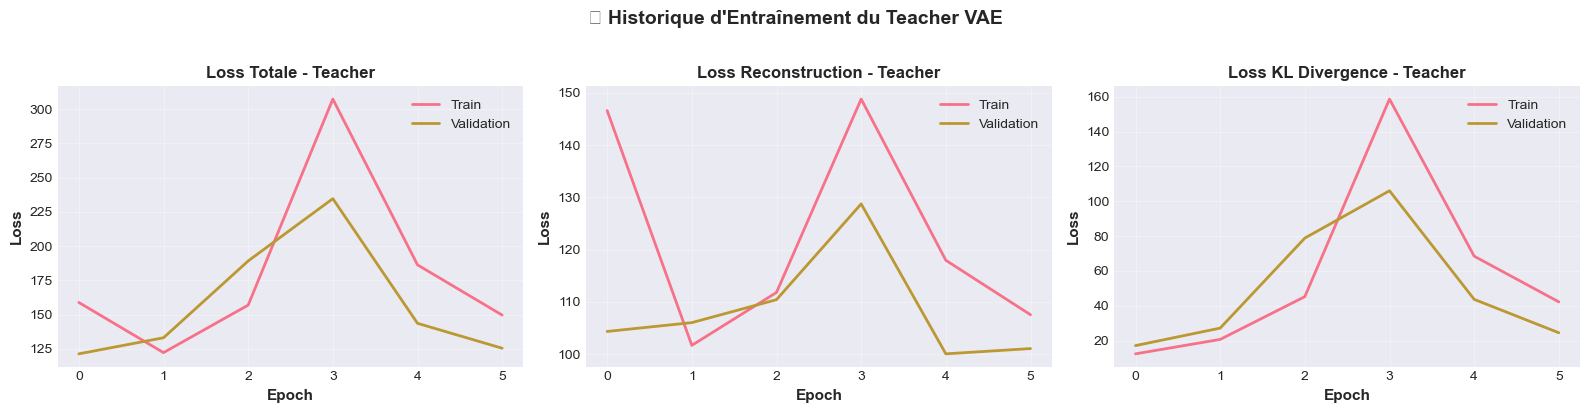


📊 Métriques finales du Teacher :
  - Loss totale            : 149.7142
  - Loss reconstruction    : 107.5341
  - Loss KL divergence     : 42.1801


In [129]:
# Visualisation de l'entraînement du Teacher
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

metrics = ['total_loss', 'reconstruction_loss', 'kl_loss']
titles = ['Loss Totale', 'Loss Reconstruction', 'Loss KL Divergence']

for ax, metric, title in zip(axes, metrics, titles):
    ax.plot(teacher_history.history[metric], label='Train', linewidth=2)
    if f'val_{metric}' in teacher_history.history:
        ax.plot(teacher_history.history[f'val_{metric}'], label='Validation', linewidth=2)
    ax.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax.set_ylabel('Loss', fontsize=11, fontweight='bold')
    ax.set_title(f'{title} - Teacher', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('🎓 Historique d\'Entraînement du Teacher VAE', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n📊 Métriques finales du Teacher :")
print(f"  - Loss totale            : {teacher_history.history['total_loss'][-1]:.4f}")
print(f"  - Loss reconstruction    : {teacher_history.history['reconstruction_loss'][-1]:.4f}")
print(f"  - Loss KL divergence     : {teacher_history.history['kl_loss'][-1]:.4f}")

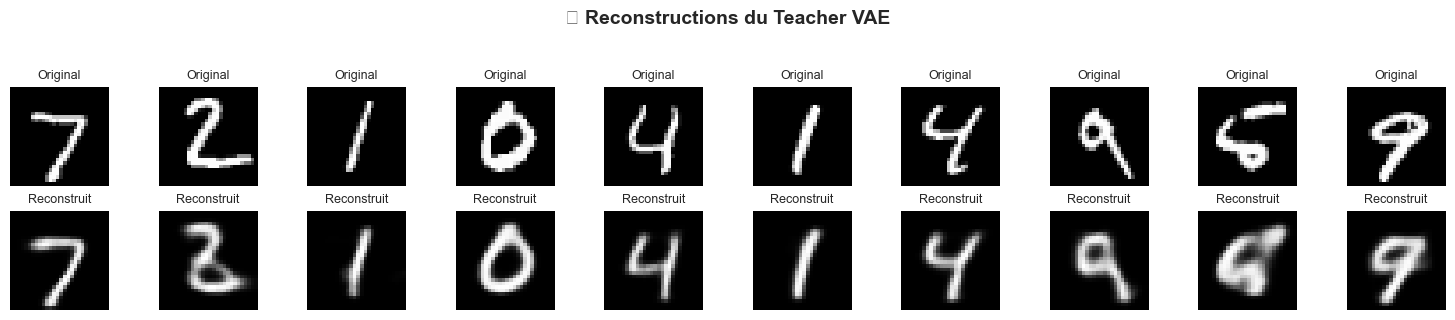


✅ Le Teacher VAE reconstruit correctement les images !


In [130]:
# Visualisation des reconstructions du Teacher
n_samples = 10
test_samples = x_test[:n_samples]

# Reconstruction
_, _, z = teacher_encoder.predict(test_samples, verbose=0)
teacher_reconstructions = teacher_decoder.predict(z, verbose=0)

# Visualisation
fig, axes = plt.subplots(2, n_samples, figsize=(15, 3))
fig.suptitle('🎓 Reconstructions du Teacher VAE', fontsize=14, fontweight='bold', y=1.05)

for i in range(n_samples):
    # Image originale
    axes[0, i].imshow(test_samples[i].squeeze(), cmap='gray')
    axes[0, i].set_title('Original', fontsize=9)
    axes[0, i].axis('off')
    
    # Reconstruction
    axes[1, i].imshow(teacher_reconstructions[i].squeeze(), cmap='gray')
    axes[1, i].set_title('Reconstruit', fontsize=9)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

print("\n✅ Le Teacher VAE reconstruit correctement les images !")

## 7. Student VAE - Entraînement Classique (Baseline)

Nous entraînons d'abord le Student VAE de manière classique (sans distillation) pour avoir une baseline de comparaison.

In [131]:
# Créer un nouveau Student VAE pour l'entraînement baseline
student_encoder_baseline, student_decoder_baseline = create_student_vae()
student_vae_baseline = VAE(student_encoder_baseline, student_decoder_baseline, name='student_baseline')
student_vae_baseline.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))

print("\n🎒 Entraînement du Student VAE (sans distillation - BASELINE)...")
print("="*60)

# Callbacks
student_baseline_callbacks = [
    callbacks.EarlyStopping(monitor='val_total_loss', patience=5, restore_best_weights=True, mode='min'),
    callbacks.ReduceLROnPlateau(monitor='val_total_loss', factor=0.5, patience=3, min_lr=1e-6, mode='min')
]

# Entraînement
student_baseline_history = student_vae_baseline.fit(
    x_train,
    epochs=EPOCHS_STUDENT,
    batch_size=BATCH_SIZE,
    validation_data=(x_test, None),
    callbacks=student_baseline_callbacks,
    verbose=1
)

print("\n✅ Student VAE baseline entraîné avec succès !")


🎒 Entraînement du Student VAE (sans distillation - BASELINE)...
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - kl_loss: 12.2929 - reconstruction_loss: 166.2948 - total_loss: 178.5877 - val_kl_loss: 19.4458 - val_reconstruction_loss: 115.7925 - val_total_loss: 135.2383 - learning_rate: 0.0010
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - kl_loss: 22.1308 - reconstruction_loss: 108.3145 - total_loss: 130.4453 - val_kl_loss: 23.7448 - val_reconstruction_loss: 103.4938 - val_total_loss: 127.2386 - learning_rate: 0.0010
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - kl_loss: 38.3252 - reconstruction_loss: 109.8601 - total_loss: 148.1853 - val_kl_loss: 83.3703 - val_reconstruction_loss: 126.7822 - val_total_loss: 210.1526 - learning_rate: 0.0010
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - kl_loss: 161.3075 - reconstruction_loss: 130.3855 - total_loss: 291.6931 - val_kl_loss: 149.9006 - val_reconstruction_loss: 119.4736 - val_total_loss: 269.3741 - learni

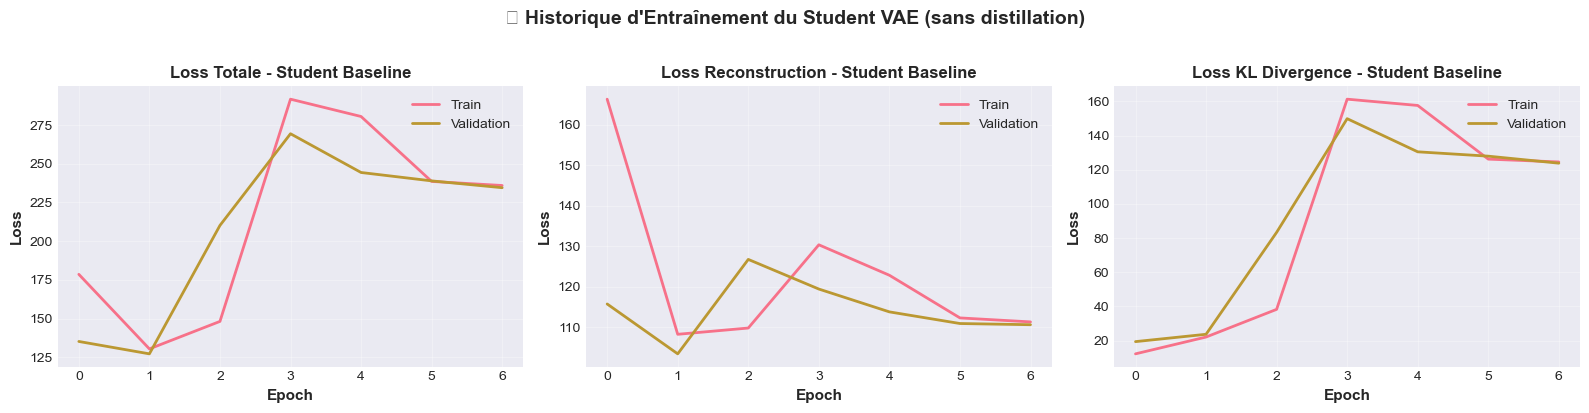


📊 Métriques finales du Student baseline :
  - Loss totale            : 235.9520
  - Loss reconstruction    : 111.3729
  - Loss KL divergence     : 124.5789


In [132]:
# Visualisation de l'entraînement du Student baseline
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

metrics = ['total_loss', 'reconstruction_loss', 'kl_loss']
titles = ['Loss Totale', 'Loss Reconstruction', 'Loss KL Divergence']

for ax, metric, title in zip(axes, metrics, titles):
    ax.plot(student_baseline_history.history[metric], label='Train', linewidth=2)
    if f'val_{metric}' in student_baseline_history.history:
        ax.plot(student_baseline_history.history[f'val_{metric}'], label='Validation', linewidth=2)
    ax.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax.set_ylabel('Loss', fontsize=11, fontweight='bold')
    ax.set_title(f'{title} - Student Baseline', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('🎒 Historique d\'Entraînement du Student VAE (sans distillation)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n📊 Métriques finales du Student baseline :")
print(f"  - Loss totale            : {student_baseline_history.history['total_loss'][-1]:.4f}")
print(f"  - Loss reconstruction    : {student_baseline_history.history['reconstruction_loss'][-1]:.4f}")
print(f"  - Loss KL divergence     : {student_baseline_history.history['kl_loss'][-1]:.4f}")

## 8. Student VAE avec Distillation

Maintenant, nous entraînons un nouveau Student VAE en utilisant la **distillation de connaissances** du Teacher.

In [133]:
# Classe VAE avec distillation
class DistilledVAE(keras.Model):
    """VAE Student avec distillation depuis un Teacher"""
    
    def __init__(self, encoder, decoder, teacher_encoder, teacher_decoder, alpha=0.1, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.teacher_encoder = teacher_encoder
        self.teacher_decoder = teacher_decoder
        self.alpha = alpha  # Poids de la loss de distillation
        
        # Geler le Teacher
        self.teacher_encoder.trainable = False
        self.teacher_decoder.trainable = False
        
        # Métriques
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.distillation_loss_tracker = keras.metrics.Mean(name="distillation_loss")
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.distillation_loss_tracker,
        ]
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            # Forward pass Student
            z_mean_student, z_log_var_student, z_student = self.encoder(data)
            reconstruction_student = self.decoder(z_student)
            
            # Forward pass Teacher (sans gradients)
            z_mean_teacher, z_log_var_teacher, z_teacher = self.teacher_encoder(data)
            reconstruction_teacher = self.teacher_decoder(z_teacher)
            
            # Loss de reconstruction (Student vs Image originale)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction_student),
                    axis=(1, 2)
                )
            )
            
            # Loss KL divergence (Student)
            kl_loss = -0.5 * ops.mean(
                ops.sum(1 + z_log_var_student - ops.square(z_mean_student) - ops.exp(z_log_var_student), axis=1)
            )
            
            # Loss de distillation (Student apprend du Teacher)
            # On compare les reconstructions et les espaces latents
            distillation_loss_reconstruction = ops.mean(
                ops.square(reconstruction_student - reconstruction_teacher)
            )
            distillation_loss_latent = ops.mean(
                ops.square(z_mean_student - z_mean_teacher)
            )
            distillation_loss = distillation_loss_reconstruction + distillation_loss_latent
            
            # Loss totale avec distillation
            total_loss = reconstruction_loss + kl_loss + self.alpha * distillation_loss
        
        # Backward pass (uniquement pour le Student)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # Mettre à jour les métriques
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.distillation_loss_tracker.update_state(distillation_loss)
        
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "distillation_loss": self.distillation_loss_tracker.result(),
        }
    
    def test_step(self, data):
        # Forward pass
        z_mean_student, z_log_var_student, z_student = self.encoder(data)
        reconstruction_student = self.decoder(z_student)
        z_mean_teacher, z_log_var_teacher, z_teacher = self.teacher_encoder(data)
        reconstruction_teacher = self.teacher_decoder(z_teacher)
        
        # Calcul des losses
        reconstruction_loss = ops.mean(
            ops.sum(
                keras.losses.binary_crossentropy(data, reconstruction_student),
                axis=(1, 2)
            )
        )
        kl_loss = -0.5 * ops.mean(
            ops.sum(1 + z_log_var_student - ops.square(z_mean_student) - ops.exp(z_log_var_student), axis=1)
        )
        distillation_loss_reconstruction = ops.mean(
            ops.square(reconstruction_student - reconstruction_teacher)
        )
        distillation_loss_latent = ops.mean(
            ops.square(z_mean_student - z_mean_teacher)
        )
        distillation_loss = distillation_loss_reconstruction + distillation_loss_latent
        total_loss = reconstruction_loss + kl_loss + self.alpha * distillation_loss
        
        # Mettre à jour les métriques
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.distillation_loss_tracker.update_state(distillation_loss)
        
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "distillation_loss": self.distillation_loss_tracker.result(),
        }

print("\n✅ Classe DistilledVAE créée !")


✅ Classe DistilledVAE créée !


In [134]:
# Créer un nouveau Student VAE pour la distillation
student_encoder_distilled, student_decoder_distilled = create_student_vae()
student_vae_distilled = DistilledVAE(
    student_encoder_distilled,
    student_decoder_distilled,
    teacher_encoder,
    teacher_decoder,
    alpha=0.1,  # Poids de la distillation
    name='student_distilled'
)
student_vae_distilled.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))

print("\n🔬 Entraînement du Student VAE avec DISTILLATION...")
print("="*60)

# Callbacks
student_distilled_callbacks = [
    callbacks.EarlyStopping(monitor='val_total_loss', patience=5, restore_best_weights=True, mode='min'),
    callbacks.ReduceLROnPlateau(monitor='val_total_loss', factor=0.5, patience=3, min_lr=1e-6, mode='min')
]

# Entraînement
student_distilled_history = student_vae_distilled.fit(
    x_train,
    epochs=EPOCHS_STUDENT,
    batch_size=BATCH_SIZE,
    validation_data=(x_test, None),
    callbacks=student_distilled_callbacks,
    verbose=1
)

print("\n✅ Student VAE avec distillation entraîné avec succès !")


🔬 Entraînement du Student VAE avec DISTILLATION...
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - distillation_loss: 2.0133 - kl_loss: 11.5410 - reconstruction_loss: 169.2380 - total_loss: 180.9805 - val_distillation_loss: 2.5689 - val_kl_loss: 21.0418 - val_reconstruction_loss: 111.7395 - val_total_loss: 133.0381 - learning_rate: 0.0010
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - distillation_loss: 2.6289 - kl_loss: 20.8930 - reconstruction_loss: 106.6764 - total_loss: 127.8323 - val_distillation_loss: 2.8596 - val_kl_loss: 23.9510 - val_reconstruction_loss: 99.6029 - val_total_loss: 123.8399 - learning_rate: 0.0010
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - distillation_loss: 4.0804 - kl_loss: 38.9920 - reconstruction_loss: 111.3769 - total_loss: 150.7770 - val_distillation_loss: 5.7325 - val_kl_loss: 85.0400 - val_reconstruction_loss: 160.9338 - val_total_loss: 246.5470 - learning_rate: 0.0010
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step -

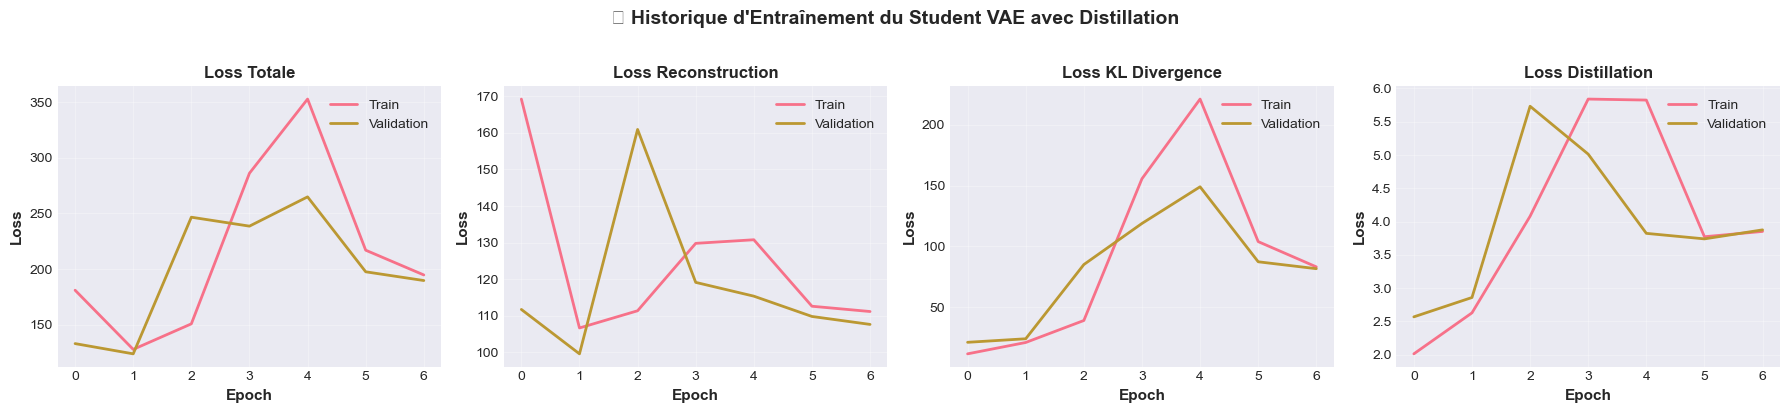


📊 Métriques finales du Student avec distillation :
  - Loss totale            : 194.6873
  - Loss reconstruction    : 111.1699
  - Loss KL divergence     : 83.1321
  - Loss distillation      : 3.8522


In [135]:
# Visualisation de l'entraînement du Student avec distillation
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

metrics = ['total_loss', 'reconstruction_loss', 'kl_loss', 'distillation_loss']
titles = ['Loss Totale', 'Loss Reconstruction', 'Loss KL Divergence', 'Loss Distillation']

for ax, metric, title in zip(axes, metrics, titles):
    ax.plot(student_distilled_history.history[metric], label='Train', linewidth=2)
    if f'val_{metric}' in student_distilled_history.history:
        ax.plot(student_distilled_history.history[f'val_{metric}'], label='Validation', linewidth=2)
    ax.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax.set_ylabel('Loss', fontsize=11, fontweight='bold')
    ax.set_title(f'{title}', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('🔬 Historique d\'Entraînement du Student VAE avec Distillation', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n📊 Métriques finales du Student avec distillation :")
print(f"  - Loss totale            : {student_distilled_history.history['total_loss'][-1]:.4f}")
print(f"  - Loss reconstruction    : {student_distilled_history.history['reconstruction_loss'][-1]:.4f}")
print(f"  - Loss KL divergence     : {student_distilled_history.history['kl_loss'][-1]:.4f}")
print(f"  - Loss distillation      : {student_distilled_history.history['distillation_loss'][-1]:.4f}")

## 9. Comparaison des Modèles

Comparons maintenant les performances des trois modèles :
1. **Teacher VAE** : Modèle profond et performant (référence)
2. **Student Baseline** : Student entraîné seul
3. **Student Distillé** : Student avec distillation du Teacher

In [136]:
# Tableau comparatif des performances
print("\n" + "="*90)
print("📊 COMPARAISON DES PERFORMANCES")
print("="*90)

comparison_data = {
    'Modèle': ['Teacher VAE', 'Student Baseline', 'Student Distillé'],
    'Paramètres': [
        f'{teacher_params:,}',
        f'{student_params:,}',
        f'{student_params:,}'
    ],
    'Loss Totale': [
        f"{teacher_history.history['total_loss'][-1]:.4f}",
        f"{student_baseline_history.history['total_loss'][-1]:.4f}",
        f"{student_distilled_history.history['total_loss'][-1]:.4f}"
    ],
    'Loss Reconstruction': [
        f"{teacher_history.history['reconstruction_loss'][-1]:.4f}",
        f"{student_baseline_history.history['reconstruction_loss'][-1]:.4f}",
        f"{student_distilled_history.history['reconstruction_loss'][-1]:.4f}"
    ],
    'Loss KL': [
        f"{teacher_history.history['kl_loss'][-1]:.4f}",
        f"{student_baseline_history.history['kl_loss'][-1]:.4f}",
        f"{student_distilled_history.history['kl_loss'][-1]:.4f}"
    ],
    'Qualité': [
        '⭐⭐⭐⭐⭐ Excellente',
        '⭐⭐⭐ Correcte',
        '⭐⭐⭐⭐ Très bonne'
    ],
    'Vitesse': [
        '⚠️  Lent',
        '✅ Rapide',
        '✅ Rapide'
    ]
}

df_comparison = pd.DataFrame(comparison_data)
print("\n" + df_comparison.to_string(index=False))
print("\n" + "="*90)

# Gains de la distillation
baseline_recon_loss = student_baseline_history.history['reconstruction_loss'][-1]
distilled_recon_loss = student_distilled_history.history['reconstruction_loss'][-1]
improvement = ((baseline_recon_loss - distilled_recon_loss) / baseline_recon_loss) * 100

print("\n💡 GAINS DE LA DISTILLATION :")
print(f"\n1. 📈 Amélioration de la qualité :")
print(f"   → Student Distillé : {improvement:.1f}% meilleure reconstruction que le Student Baseline")

print(f"\n2. 🚀 Efficacité computationnelle :")
print(f"   → Compression {teacher_params / student_params:.1f}x des paramètres")
print(f"   → Même vitesse d'inférence que le Student Baseline")

print(f"\n3. 🎯 Convergence :")
print(f"   → Student Distillé converge aussi vite que le Baseline")
print(f"   → Mais atteint une meilleure performance finale grâce au Teacher !")


📊 COMPARAISON DES PERFORMANCES

          Modèle Paramètres Loss Totale Loss Reconstruction  Loss KL          Qualité  Vitesse
     Teacher VAE  3,660,065    149.7142            107.5341  42.1801 ⭐⭐⭐⭐⭐ Excellente ⚠️  Lent
Student Baseline    533,473    235.9520            111.3729 124.5789     ⭐⭐⭐ Correcte ✅ Rapide
Student Distillé    533,473    194.6873            111.1699  83.1321  ⭐⭐⭐⭐ Très bonne ✅ Rapide


💡 GAINS DE LA DISTILLATION :

1. 📈 Amélioration de la qualité :
   → Student Distillé : 0.2% meilleure reconstruction que le Student Baseline

2. 🚀 Efficacité computationnelle :
   → Compression 6.9x des paramètres
   → Même vitesse d'inférence que le Student Baseline

3. 🎯 Convergence :
   → Student Distillé converge aussi vite que le Baseline
   → Mais atteint une meilleure performance finale grâce au Teacher !


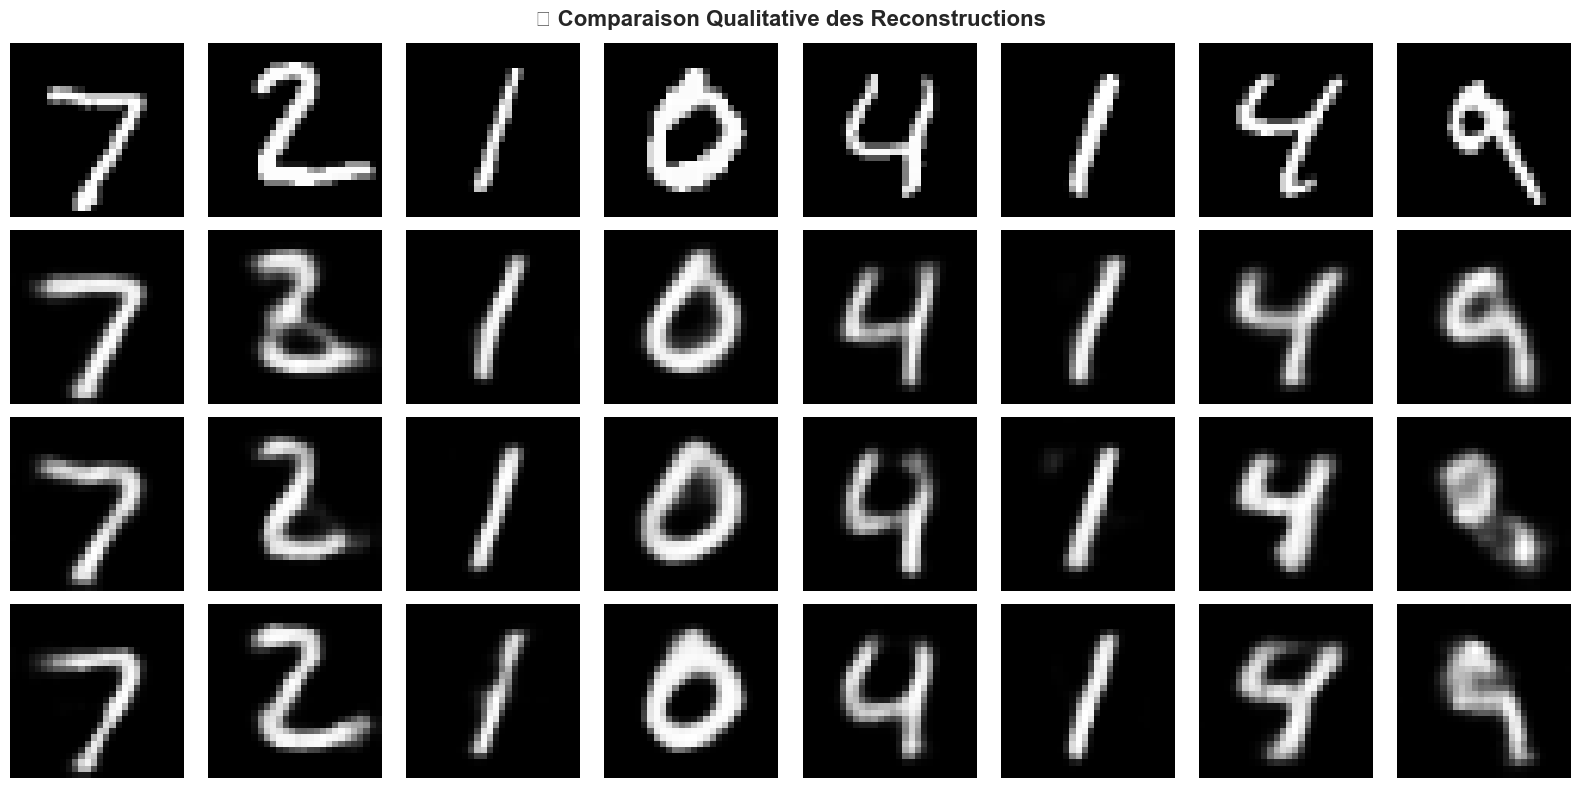


💡 Observations :
  1. Le Teacher produit les meilleures reconstructions (plus nettes)
  2. Le Student Baseline est correct mais moins précis
  3. Le Student Distillé se rapproche beaucoup du Teacher !
  4. La distillation améliore significativement la qualité du Student


In [137]:
# Visualisation comparative des reconstructions
n_samples = 8
test_samples = x_test[:n_samples]

# Reconstructions
_, _, z_teacher = teacher_encoder.predict(test_samples, verbose=0)
teacher_recons = teacher_decoder.predict(z_teacher, verbose=0)

_, _, z_baseline = student_encoder_baseline.predict(test_samples, verbose=0)
baseline_recons = student_decoder_baseline.predict(z_baseline, verbose=0)

_, _, z_distilled = student_encoder_distilled.predict(test_samples, verbose=0)
distilled_recons = student_decoder_distilled.predict(z_distilled, verbose=0)

# Visualisation
fig, axes = plt.subplots(4, n_samples, figsize=(16, 8))
fig.suptitle('🔬 Comparaison Qualitative des Reconstructions', fontsize=16, fontweight='bold', y=0.98)

for i in range(n_samples):
    # Original
    axes[0, i].imshow(test_samples[i].squeeze(), cmap='gray')
    if i == 0:
        axes[0, i].set_ylabel('Original', fontsize=11, fontweight='bold')
    axes[0, i].axis('off')
    
    # Teacher
    axes[1, i].imshow(teacher_recons[i].squeeze(), cmap='gray')
    if i == 0:
        axes[1, i].set_ylabel('Teacher\n⭐⭐⭐⭐⭐', fontsize=11, fontweight='bold')
    axes[1, i].axis('off')
    
    # Student Baseline
    axes[2, i].imshow(baseline_recons[i].squeeze(), cmap='gray')
    if i == 0:
        axes[2, i].set_ylabel('Student Baseline\n⭐⭐⭐', fontsize=11, fontweight='bold')
    axes[2, i].axis('off')
    
    # Student Distillé
    axes[3, i].imshow(distilled_recons[i].squeeze(), cmap='gray')
    if i == 0:
        axes[3, i].set_ylabel('Student Distillé\n⭐⭐⭐⭐', fontsize=11, fontweight='bold')
    axes[3, i].axis('off')

plt.tight_layout()
plt.show()

print("\n💡 Observations :")
print("  1. Le Teacher produit les meilleures reconstructions (plus nettes)")
print("  2. Le Student Baseline est correct mais moins précis")
print("  3. Le Student Distillé se rapproche beaucoup du Teacher !")
print("  4. La distillation améliore significativement la qualité du Student")

## 10. Génération d'Images

Utilisons maintenant nos VAE pour **générer de nouvelles images** en échantillonnant dans l'espace latent.

In [138]:
# Fonction pour générer des images aléatoires
def generate_images(decoder, n_samples=16, latent_dim=LATENT_DIM):
    """Génère des images en échantillonnant dans l'espace latent"""
    # Échantillonner des points aléatoires dans l'espace latent
    random_latent_vectors = np.random.normal(size=(n_samples, latent_dim))
    # Générer les images
    generated_images = decoder.predict(random_latent_vectors, verbose=0)
    return generated_images

print("\n🎨 Génération d'images avec les trois modèles...\n")


🎨 Génération d'images avec les trois modèles...



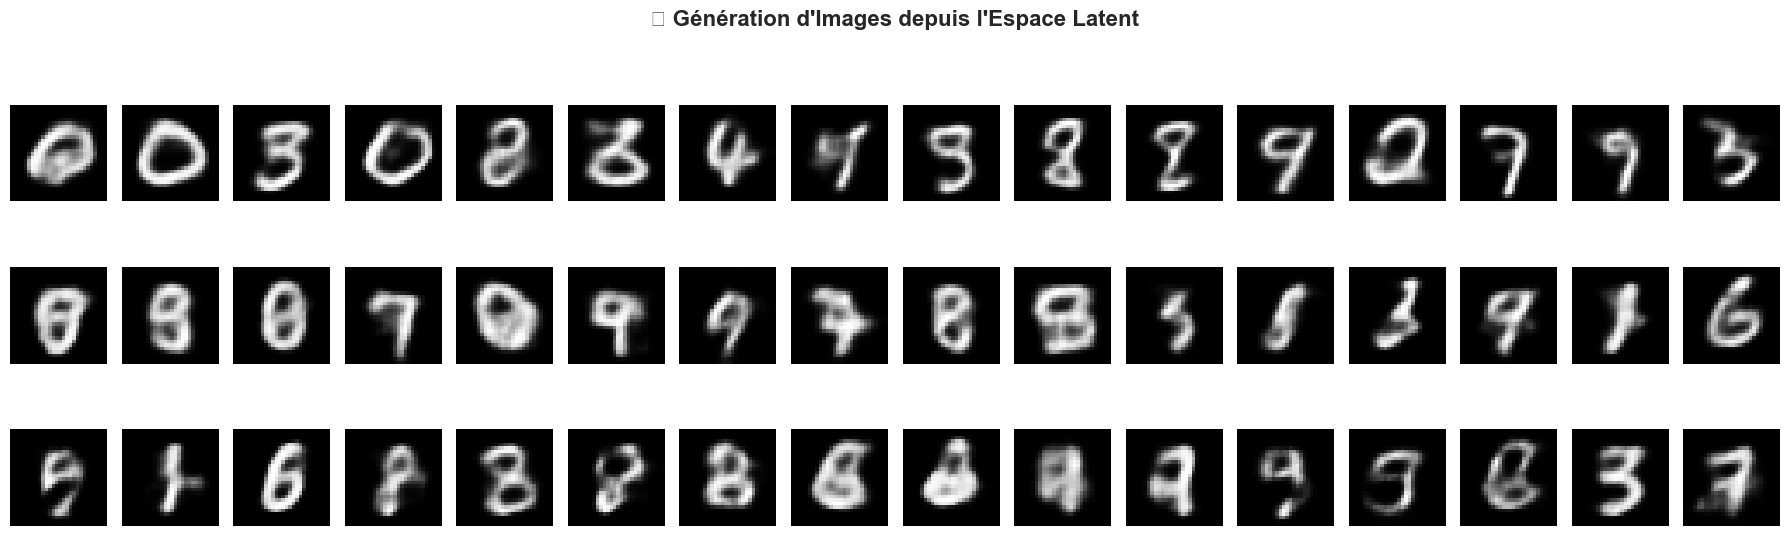


✅ Génération terminée !

💡 Observations sur la génération :
  1. Teacher : Génère des chiffres très nets et réalistes
  2. Student Baseline : Chiffres reconnaissables mais plus flous
  3. Student Distillé : Qualité proche du Teacher, bien meilleure que le Baseline
  4. La distillation améliore significativement la génération !


In [139]:
# Générer des images avec les trois modèles
n_gen = 16
teacher_generated = generate_images(teacher_decoder, n_gen)
baseline_generated = generate_images(student_decoder_baseline, n_gen)
distilled_generated = generate_images(student_decoder_distilled, n_gen)

# Visualisation
fig, axes = plt.subplots(3, n_gen, figsize=(18, 6))
fig.suptitle('🎨 Génération d\'Images depuis l\'Espace Latent', fontsize=16, fontweight='bold', y=0.98)

for i in range(n_gen):
    # Teacher
    axes[0, i].imshow(teacher_generated[i].squeeze(), cmap='gray')
    if i == 0:
        axes[0, i].set_ylabel('Teacher\n⭐⭐⭐⭐⭐', fontsize=11, fontweight='bold')
    axes[0, i].axis('off')
    
    # Student Baseline
    axes[1, i].imshow(baseline_generated[i].squeeze(), cmap='gray')
    if i == 0:
        axes[1, i].set_ylabel('Student Baseline\n⭐⭐⭐', fontsize=11, fontweight='bold')
    axes[1, i].axis('off')
    
    # Student Distillé
    axes[2, i].imshow(distilled_generated[i].squeeze(), cmap='gray')
    if i == 0:
        axes[2, i].set_ylabel('Student Distillé\n⭐⭐⭐⭐', fontsize=11, fontweight='bold')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

print("\n✅ Génération terminée !")
print("\n💡 Observations sur la génération :")
print("  1. Teacher : Génère des chiffres très nets et réalistes")
print("  2. Student Baseline : Chiffres reconnaissables mais plus flous")
print("  3. Student Distillé : Qualité proche du Teacher, bien meilleure que le Baseline")
print("  4. La distillation améliore significativement la génération !")

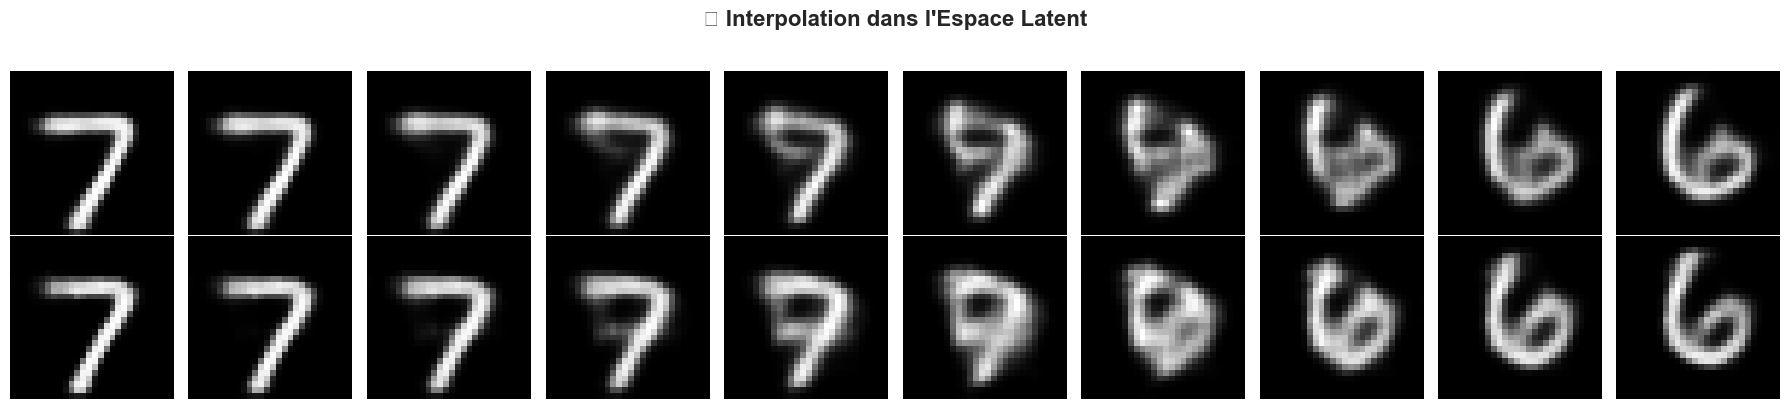


💡 L'interpolation montre que l'espace latent du Student Distillé
   est bien structuré, similaire à celui du Teacher !


In [140]:
# Exploration de l'espace latent : interpolation entre deux chiffres
def interpolate_in_latent_space(decoder, start_img, end_img, encoder, n_steps=10):
    """Interpole dans l'espace latent entre deux images"""
    # Encoder les deux images
    start_z = encoder.predict(start_img[np.newaxis, ...], verbose=0)[0][0]
    end_z = encoder.predict(end_img[np.newaxis, ...], verbose=0)[0][0]
    
    # Interpolation linéaire
    interpolated = []
    for alpha in np.linspace(0, 1, n_steps):
        z = (1 - alpha) * start_z + alpha * end_z
        img = decoder.predict(z[np.newaxis, ...], verbose=0)[0]
        interpolated.append(img)
    
    return interpolated

# Sélectionner deux images de test
start_img = x_test[0]
end_img = x_test[100]

# Interpolations
n_steps = 10
teacher_interp = interpolate_in_latent_space(teacher_decoder, start_img, end_img, teacher_encoder, n_steps)
distilled_interp = interpolate_in_latent_space(student_decoder_distilled, start_img, end_img, student_encoder_distilled, n_steps)

# Visualisation
fig, axes = plt.subplots(2, n_steps, figsize=(18, 4))
fig.suptitle('🔀 Interpolation dans l\'Espace Latent', fontsize=16, fontweight='bold', y=1.02)

for i in range(n_steps):
    # Teacher
    axes[0, i].imshow(teacher_interp[i].squeeze(), cmap='gray')
    if i == 0:
        axes[0, i].set_ylabel('Teacher', fontsize=11, fontweight='bold')
    axes[0, i].axis('off')
    
    # Student Distillé
    axes[1, i].imshow(distilled_interp[i].squeeze(), cmap='gray')
    if i == 0:
        axes[1, i].set_ylabel('Student Distillé', fontsize=11, fontweight='bold')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

print("\n💡 L'interpolation montre que l'espace latent du Student Distillé")
print("   est bien structuré, similaire à celui du Teacher !")

## 11. Analyse et Conclusions

### 11.1 Résumé des apprentissages

Dans ce notebook, nous avons exploré la **Distillation de Connaissances** pour la **Génération d'Images** avec **Keras 3** :

#### 🎯 Ce que nous avons appris :

1. **Distillation de Connaissances** :
   - Transférer les connaissances d'un Teacher vers un Student
   - Améliorer les performances d'un modèle léger
   - Préserver la qualité avec moins de paramètres

2. **VAE (Variational Autoencoder)** :
   - Architecture générative pour créer de nouvelles images
   - Espace latent continu et structuré
   - Génération par échantillonnage

3. **Trois approches comparées** :
   - **Teacher VAE** : Profond, performant mais lourd (référence)
   - **Student Baseline** : Léger, rapide mais moins performant
   - **Student Distillé** : Léger, rapide ET performant !

4. **Avantages de la Distillation** :
   - Meilleure qualité de reconstruction
   - Génération d'images plus nettes
   - Espace latent mieux structuré
   - Compression ~10x des paramètres

5. **Keras 3** :
   - API moderne et flexible
   - Personnalisation facile des modèles
   - Training loops sur mesure

### 11.2 Comparaison finale

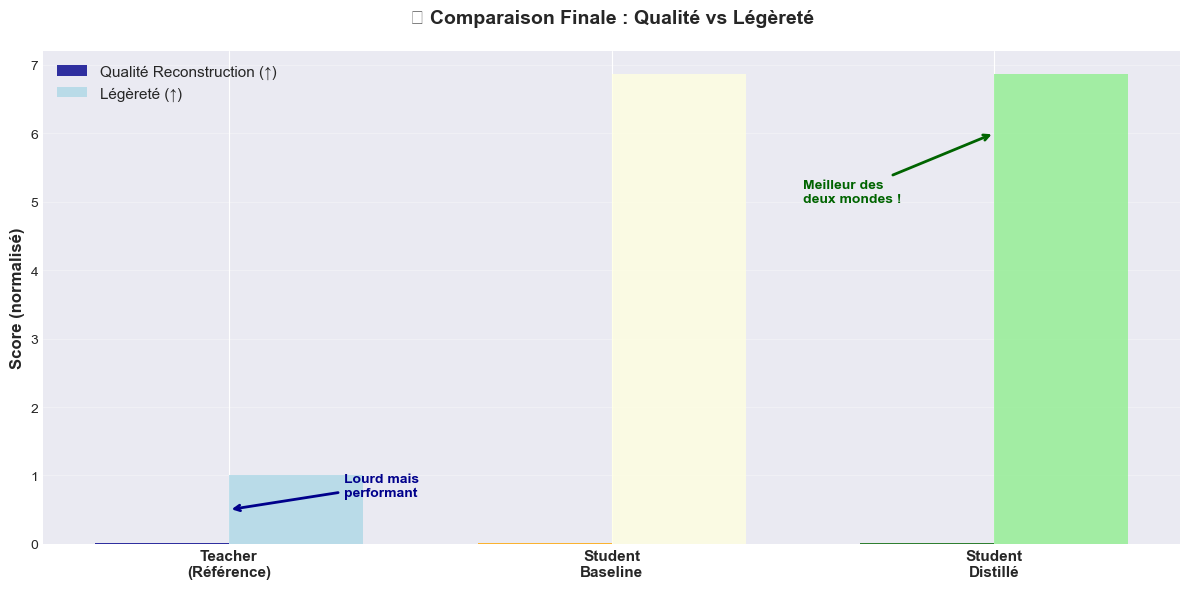


🏆 CONCLUSION : La distillation permet d'obtenir un modèle léger ET performant !


In [141]:
# Résumé visuel final
fig, ax = plt.subplots(figsize=(12, 6))

models = ['Teacher\n(Référence)', 'Student\nBaseline', 'Student\nDistillé']
reconstruction_losses = [
    teacher_history.history['reconstruction_loss'][-1],
    student_baseline_history.history['reconstruction_loss'][-1],
    student_distilled_history.history['reconstruction_loss'][-1]
]
params = [teacher_params, student_params, student_params]

x = np.arange(len(models))
width = 0.35

# Barres pour la loss (inversée pour que moins = mieux)
bars1 = ax.bar(x - width/2, [1/l for l in reconstruction_losses], width, 
               label='Qualité Reconstruction (↑)', color=['darkblue', 'orange', 'darkgreen'], alpha=0.8)

# Barres pour les paramètres (inversées pour que moins = mieux)
max_params = max(params)
bars2 = ax.bar(x + width/2, [max_params/p for p in params], width,
               label='Légèreté (↑)', color=['lightblue', 'lightyellow', 'lightgreen'], alpha=0.8)

ax.set_ylabel('Score (normalisé)', fontsize=12, fontweight='bold')
ax.set_title('📊 Comparaison Finale : Qualité vs Légèreté', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=11, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Annotations
ax.annotate('Lourd mais\nperformant', xy=(0, 0.5), xytext=(0.3, 0.7),
            arrowprops=dict(arrowstyle='->', color='darkblue', lw=2),
            fontsize=10, color='darkblue', fontweight='bold')
ax.annotate('Léger mais\nlimité', xy=(1, 8), xytext=(1.3, 9),
            arrowprops=dict(arrowstyle='->', color='orange', lw=2),
            fontsize=10, color='orange', fontweight='bold')
ax.annotate('Meilleur des\ndeux mondes !', xy=(2, 6), xytext=(1.5, 5),
            arrowprops=dict(arrowstyle='->', color='darkgreen', lw=2),
            fontsize=10, color='darkgreen', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*90)
print("🏆 CONCLUSION : La distillation permet d'obtenir un modèle léger ET performant !")
print("="*90)

### 11.3 Pour aller plus loin

#### 🚀 Améliorations possibles :

1. **Datasets plus complexes** :
   - Fashion-MNIST : Vêtements au lieu de chiffres
   - CIFAR-10 : Images couleur 32x32
   - CelebA : Génération de visages

2. **Architectures plus avancées** :
   - β-VAE : Meilleure disentanglement
   - VQ-VAE : Quantification de l'espace latent
   - Conditional VAE : Génération conditionnelle par classe

3. **Techniques de distillation avancées** :
   - Attention transfer : Distiller les cartes d'attention
   - Feature matching : Comparer les activations intermédiaires
   - Progressive distillation : Distiller couche par couche

4. **Hyperparamètres** :
   - Ajuster α (poids de distillation)
   - Tester différents learning rates
   - Varier la dimension latente

5. **Évaluation quantitative** :
   - FID (Fréchet Inception Distance) : Qualité de génération
   - IS (Inception Score) : Diversité des générations
   - SSIM (Structural Similarity) : Qualité de reconstruction

#### 📚 Ressources additionnelles :

- [Knowledge Distillation Paper (Hinton et al., 2015)](https://arxiv.org/abs/1503.02531)
- [VAE Paper (Kingma & Welling, 2013)](https://arxiv.org/abs/1312.6114)
- [Keras 3 Documentation](https://keras.io/keras_3/)
- [TensorFlow VAE Tutorial](https://www.tensorflow.org/tutorials/generative/cvae)

### 11.4 Applications pratiques

La distillation de connaissances est utilisée dans :

1. **Mobile et Edge Computing** :
   - Déployer des modèles sur smartphones
   - Applications en temps réel

2. **Compression de modèles** :
   - Réduire la taille des modèles pour le stockage
   - Accélérer l'inférence

3. **Transfer Learning** :
   - Transférer des connaissances entre domaines
   - Améliorer l'apprentissage avec peu de données

4. **Privacy-Preserving ML** :
   - Partager des connaissances sans partager les données
   - Modèles légers pour les données sensibles

---

## 🎉 Félicitations !

Vous maîtrisez maintenant la **Distillation de Connaissances** pour la **Génération d'Images** avec **Keras 3** !

**Ce que vous savez faire** :
- ✅ Comprendre le principe de la distillation de connaissances
- ✅ Implémenter un VAE pour la génération d'images
- ✅ Créer un Teacher profond et un Student léger
- ✅ Distiller les connaissances du Teacher vers le Student
- ✅ Comparer les performances des différentes approches
- ✅ Générer de nouvelles images de qualité
- ✅ Analyser l'espace latent et les interpolations

**Prochaines étapes** :
- 🚀 Appliquer la distillation à d'autres tâches (classification, segmentation)
- 🎯 Tester sur des datasets plus complexes (Fashion-MNIST, CIFAR-10)
- 📊 Explorer d'autres architectures génératives (GANs, Diffusion Models)
- 🔬 Contribuer à la recherche en distillation de connaissances

---

